# Домашнее задание к лекции «Улучшение качества модели» обновленное

In [1]:
!unzip archive.zip

Archive:  archive.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [70]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from scipy.stats import uniform

In [3]:
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('heart.csv')

In [5]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Проверим данные на пропуски

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Посмотрим на статистику

In [7]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Посмотрим на перекос целевой переменной

In [8]:
data['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

Посмотрим на уникальные значения для категориальных признаков

In [9]:
cat_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for feature in cat_features:
    print(feature, data[feature].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']


Построим диаграммы распределения числовых переменных на предмет потенциальных выбросов и отклонений.
Признак `FastingBS` не учитываем, т.к. он категориальный.



<AxesSubplot:xlabel='Oldpeak', ylabel='Density'>

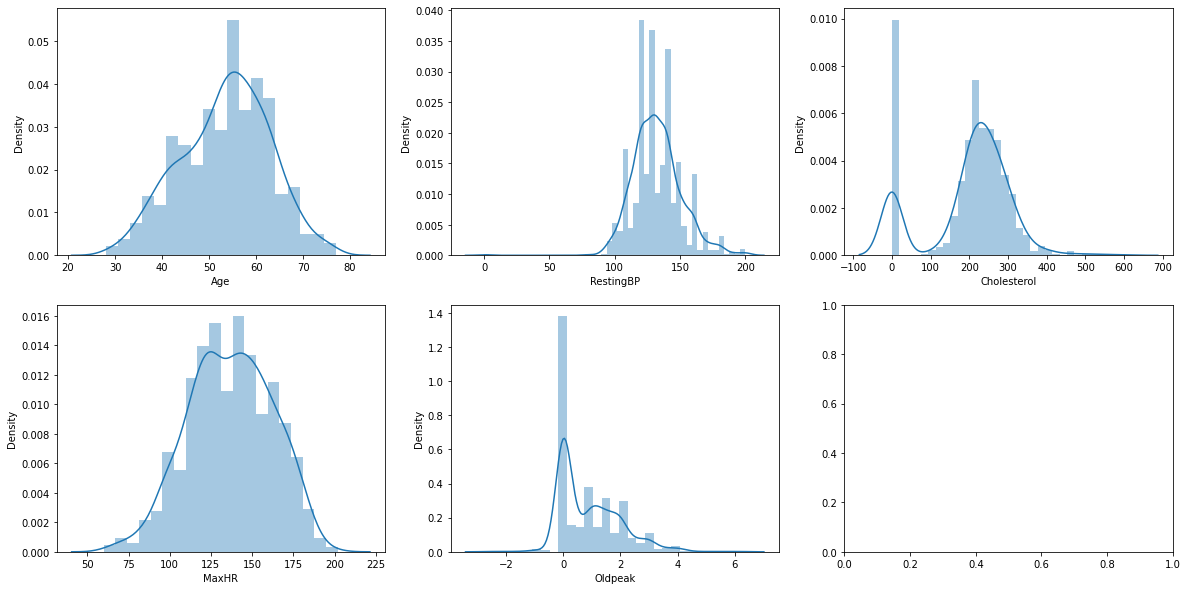

In [10]:
plt.rcParams['figure.figsize'] = 20, 10
fig, axs = plt.subplots(2,3)

sns.distplot(data['Age'], ax = axs[0,0])
sns.distplot(data['RestingBP'], ax = axs[0,1])
sns.distplot(data['Cholesterol'], ax = axs[0,2])
sns.distplot(data['MaxHR'], ax = axs[1,0])
sns.distplot(data['Oldpeak'], ax = axs[1,1])


<AxesSubplot:>

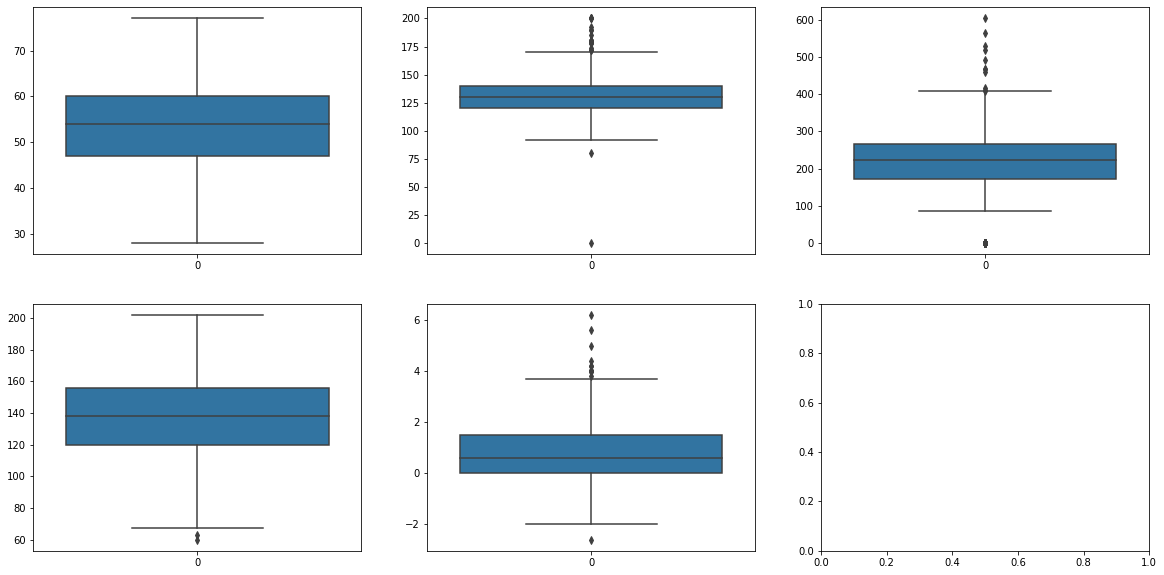

In [11]:
fig, axs = plt.subplots(2,3)

sns.boxplot(data['Age'], ax = axs[0,0])
sns.boxplot(data['RestingBP'], ax = axs[0,1])
sns.boxplot(data['Cholesterol'], ax = axs[0,2])
sns.boxplot(data['MaxHR'], ax = axs[1,0])
sns.boxplot(data['Oldpeak'], ax = axs[1,1])


`RestingBP` (артериальное давление в покое) не может быть равно 0.

In [12]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Заменим это значение на медианное

In [13]:
data[data['RestingBP'] == 0].loc['RestingBP'] = data['RestingBP'].median()

Преобразуем категориальные переменные с помощью One-hot encoding

In [14]:
data = pd.get_dummies(data, columns=cat_features)

Для бинарных признаков оставим только одну колонку

In [15]:
data.drop('Sex_F', axis=1, inplace=True)
data.drop('ExerciseAngina_N', axis=1, inplace=True)


Построим матрицу корреляции

<AxesSubplot:>

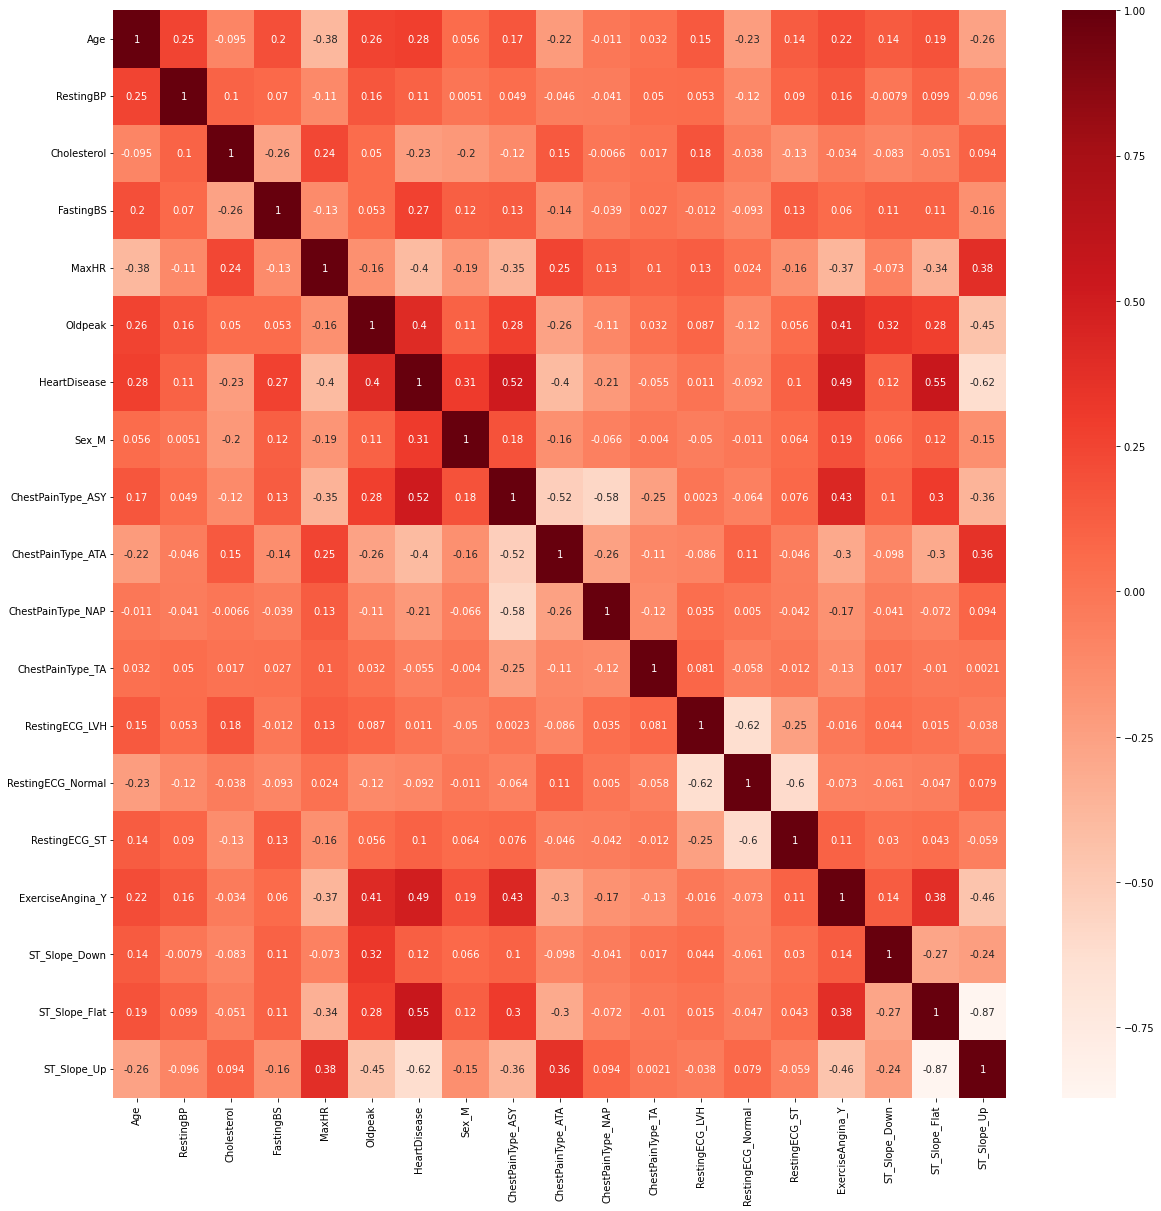

In [16]:
plt.rcParams['figure.figsize'] = 20, 20
sns.heatmap(data.corr(), cmap="Reds", annot=True)

Заметны значительные корреляции целевой переменной от некоторых признаков(`ExerciseAngina`, `ST_Slope`, `ChestPainType`, `Oldpeak`, `Sex`)

## Обучение моделей
### Базовая модель Логистической регрессии


In [17]:
y = data['HeartDisease']
X = data.drop('HeartDisease', axis=1)

Для базовой модели построим пайплайн, включающий в себя StandardScaler

In [18]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))

Функция для отображения средних значений метрик кроссвалидации

In [19]:
def mean_scores(cv: Dict) -> None:
    for score in ['accuracy', 'recall', 'precision', 'f1']:
        print(f"Mean {score}: {cv[f'test_{score}'].mean()}")


С помощью кросс-валидации получим средние метрики модели

In [20]:
cv = cross_validate(pipeline, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])

In [21]:
mean_scores(cv)

Mean accuracy: 0.8505613951266126
Mean recall: 0.8695686274509804
Mean precision: 0.8672245963837405
Mean f1: 0.8639330979700997


### Логистическая регрессия с GridSearchCV

Задаем пространство параметров

In [51]:
params = {
    "logisticregression__C": np.linspace(0.01, 3, num=10),
    "logisticregression__tol": np.linspace(1E-6, 1E-2, num=10),
    "logisticregression__max_iter": np.linspace(5, 10000, num=10)
}

Создаем модель, подбираем параметры и выводим результат

In [52]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
grid = GridSearchCV(pipeline, params, n_jobs=-1)
grid.fit(X, y)

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anonymous/Projects/lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([0.01      , 0.34222222, 0.67444444, 1.00666667, 1.33888889,
       1.67111111, 2.00333333, 2.33555556, 2.66777778, 3.        ]),
                         'logisticregression__max_iter': array([5.00000000e+00, 1.11555556e+03, 2.22611111e+03, 3.33666667e+03,
       4.44722222e+03, 5.55777778e+03, 6.66833333e+03, 7.77888889e+03,
       8.88944444e+03, 1.00000000e+04]),
                         'logisticregression__tol': array([1.000e-06, 1.112e-03, 2.223e-03, 3.334e-03, 4.445e-03, 5.556e-03,
       6.667e-03, 7.778e-03, 8.889e-03, 1.000e-02])})

Посмотрим на наилучшие параметры

In [53]:
grid.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__max_iter': 1115.5555555555557,
 'logisticregression__tol': 1e-06}

Создадим новую модель с полученными параметрами и вычислим метрики качества

In [55]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(
    random_state=0,
    C=0.01,
    max_iter=1116,
    tol=1E-6
))
cv = cross_validate(pipeline, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])
mean_scores(cv)

Mean accuracy: 0.8516483516483516
Mean recall: 0.8813725490196079
Mean precision: 0.859114108931298
Mean f1: 0.866426148364076


### Логистическая регрессия и RandomizedSearchCV


In [56]:
params = {
    "logisticregression__C": uniform(loc=0.01, scale=3),
    "logisticregression__tol": uniform(loc=1E-11, scale=1E-3),
    "logisticregression__max_iter": uniform(loc=5, scale=10000)
}

In [57]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
model = RandomizedSearchCV(pipeline, params, random_state=0, n_jobs=-1)
search = model.fit(X, y)
search.best_params_

{'logisticregression__C': 0.27138789910462213,
 'logisticregression__max_iter': 207.1839744032572,
 'logisticregression__tol': 0.000832619855547938}

вычислим метрики качества

In [62]:
cv = cross_validate(search, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])
mean_scores(cv)

Mean accuracy: 0.8494744386048734
Mean recall: 0.8676078431372549
Mean precision: 0.8671461650111916
Mean f1: 0.8629041715480457


### Сравнение разных классификаторов

для сравнения возьмем следующие классификаторы:
- RidgeClassifier
- PassiveAggressiveClassifier
- BernoulliNB
- KNeighborsClassifier
- RadiusNeighborsClassifier
- LinearSVC
- DecisionTreeClassifier
- ExtraTreeClassifier

In [59]:
clfs = {
    "RidgeClassifier": {
        "model": RidgeClassifier(random_state=0),
        "params": {
            "alpha": uniform(loc=0.1, scale=5),
            "tol": uniform(loc=1E-5, scale=1E-2),
            "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
        }
    },
    "PassiveAggressiveClassifier": {
        "model": PassiveAggressiveClassifier(random_state=0),
        "params": {
            "C": uniform(loc=0.1, scale=5),
            "max_iter": uniform(loc=10, scale=900),
            "tol": uniform(loc=1E-5, scale=1E-2)
        }
    },
    "BernoulliNB": {
        "model": BernoulliNB(),
        "params": {
            "alpha": uniform(loc=0, scale=5),
            "binarize": uniform(loc=0, scale=1)
        }
    },
    "LinearSVC": {
        "model": LinearSVC(random_state=0),
        "params": {
            "penalty": ['l1', 'l2'],
            "loss": ['hinge', 'squared_hinge'],
            "tol": uniform(loc=1E-5, scale=1E-2),
            "C": uniform(loc=0.1, scale=5),
            "max_iter": uniform(loc=100, scale=10000)
        }
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(random_state=0),
        "params": {
            "criterion": ['gini', 'entropy', 'log_loss'],
            "max_depth": uniform(loc=1, scale=100),
            "min_samples_split": uniform(loc=0, scale=1),
            "min_samples_leaf": uniform(loc=0, scale=0.5),
            "max_features": ['auto', 'sqrt', 'log2', None],
            "ccp_alpha": uniform(loc=0.0, scale=5)
        }
    },
    "ExtraTreeClassifier": {
        "model": ExtraTreeClassifier(random_state=0),
        "params": {
            "criterion": ['gini', 'entropy', 'log_loss'],
            "max_depth": uniform(loc=1, scale=100),
            "min_samples_split": uniform(loc=0, scale=1),
            "min_samples_leaf": uniform(loc=0, scale=0.5),
            "max_features": ['auto', 'sqrt', 'log2', None],
            "ccp_alpha": uniform(loc=0.0, scale=5)
        }
    }
}

In [66]:
for name, model in clfs.items():
    pipeline = Pipeline([('scaler', StandardScaler()), (name, model['model'])])
    search = RandomizedSearchCV(
                             pipeline, 
                             {f'{name}__{k}': v for k,v in model['params'].items()}, random_state=0, n_jobs=-1
                            )
    model = search.fit(X, y)
    cv = cross_validate(model, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])
    print()
    print("---------------------------------")
    print(name)
    print("---------------------------------")
    mean_scores(cv)


---------------------------------
RidgeClassifier
---------------------------------
Mean accuracy: 0.8472885809842332
Mean recall: 0.8676470588235293
Mean precision: 0.8621187142253259
Mean f1: 0.8612578699721846

---------------------------------
PassiveAggressiveClassifier
---------------------------------
Mean accuracy: 0.7853081700907788
Mean recall: 0.8322352941176471
Mean precision: 0.8045727236759062
Mean f1: 0.8108672777003548

---------------------------------
BernoulliNB
---------------------------------
Mean accuracy: 0.8483994266602963
Mean recall: 0.8676470588235293
Mean precision: 0.862340140970964
Mean f1: 0.8621182525615403

---------------------------------
LinearSVC
---------------------------------
Mean accuracy: 0.8483874820831343
Mean recall: 0.869607843137255
Mean precision: 0.8621724190918295
Mean f1: 0.8625870833215705

---------------------------------
DecisionTreeClassifier
---------------------------------
Mean accuracy: 0.553368370759675
Mean recall: 1.0
Me

Получим аналогичные метрики для ансамблей моделей
#### RandomForestClassifier

In [71]:
model = RandomForestClassifier(random_state=0)
cv = cross_validate(model, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])
mean_scores(cv)

Mean accuracy: 0.8550047778308649
Mean recall: 0.877607843137255
Mean precision: 0.867847906191462
Mean f1: 0.8687206838755974


#### BaggingClassifier

In [72]:
model = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=0))
cv = cross_validate(model, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])
mean_scores(cv)

Mean accuracy: 0.8516602962255136
Mean recall: 0.8814509803921569
Mean precision: 0.8596027231263339
Mean f1: 0.8667063198296869


#### StackingClassifier

In [73]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=0)),
     ('rf', RandomForestClassifier(random_state=0)),
     ('svc', make_pipeline(StandardScaler(), LinearSVC(random_state=0)))
]
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
cv = cross_validate(model, X, y=y, cv=10, scoring=['accuracy', 'recall', 'precision', 'f1'])
mean_scores(cv)

Mean accuracy: 0.8560081223124701
Mean recall: 0.8932549019607843
Mean precision: 0.8579916809921265
Mean f1: 0.8722732939251611


### Выводы

Сводную таблицу оформим по метрике mean f1

| Модель                                        | f1    |
|-----------------------------------------------|-------|
| LogisticRegression GridSearchCV               | 0.866 |
| LogisticRegression                            | 0.864 |
| LogisticRegression RandomizedSearchCV         | 0.863 |
| LinearSVC RandomizedSearchCV                  | 0.863 |
| BernoulliNB RandomizedSearchCV                | 0.862 |
| RidgeClassifier RandomizedSearchCV            | 0.861 |
| PassiveAgressiveClassifier RandomizedSearchCV | 0.811 |
| DecisionTreeClassifier RandomizedSearchCV     | 0.712 |
| ExtraTreeClassifier RandomizedSearchCV        | 0.712 |

Сравним лучший результат с метриками, полученными для ансамблей моделей

| Модель                          | f1    |
|---------------------------------|-------|
| StackingClassifier              | 0.872 |
| RadomForestClassifier           | 0.869 |
| BaggingClassifier               | 0.867 |
| LogisticRegression GridSearchCV | 0.866 |

1. GridSearchCV + LogisticRegression дал лучший результат, однако такой метод подбора довольно медленный, для улучшения качества требуется каскад решеток
2. RandomizedSearchCV значительно быстрей GridSearch, но дает хуже результат
3. Любой метод ансамблирования дает результат лучше GridSearchCV + LogisticRegression за меньшее время